# Download and save the standard deviation of FLSE on a 1x1 degree grid 

### Imports

In [1]:

import sys
import os
import glob

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# statistics
import scipy as sci

# regridding package
import xesmf as xe

# copernicusmarine
import copernicusmarine

# SFTP
import pysftp

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
downloaddir="/scratch/es60/pjb581/AVISO/"

os.chdir(downloaddir)
os.getcwd()

from dask.diagnostics import ProgressBar
ProgressBar().register()


python version = 3.10.
numpy version = 1.26.4
pandas version = 2.2.3
scipy version = 1.15.3
xarray version = 2024.1.1
xesmf version = 0.8.10
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


### Load AVISO FSLE

In [ ]:
%%time

# Set connection options (disable host key check if needed)
cnopts = pysftp.CnOpts()
cnopts.hostkeys = None  # Don't do this in production unless you're sure

with pysftp.Connection(
    host='ftp-access.aviso.altimetry.fr',
    port=2221,
    username='pearse.buchanan@csiro.au',
    password='bPIO9e',
    cnopts=cnopts
) as sftp:
    base_path = '/value-added/lyapunov/near-real-time/global/'
    sftp.cwd(base_path)
    
    year_dirs = [d for d in sftp.listdir() if d.isdigit() and int(d) >= 2023]

    for year in sorted(year_dirs):
        print(f"\nProcessing year {year}...")
        sftp.cwd(f"{base_path}{year}/")
        files = sftp.listdir()
        nc_files = [f for f in files if f.endswith('.nc')]

        print(f"  Found {len(nc_files)} NetCDF files.")

        # Create subfolder for this year
        year_local_dir = os.path.join(downloaddir, year)
        os.makedirs(year_local_dir, exist_ok=True)

        for file in nc_files:
            local_file = os.path.join(year_local_dir, file)
            if not os.path.exists(local_file):
                print(f"    Downloading {file}...")
                sftp.get(file, local_file)
            else:
                print(f"    Skipping {file} (already exists)")

print("Download complete.")



Processing year 2023...
  Found 365 NetCDF files.


### Load the data

In [10]:
ds = xr.open_mfdataset(
    './dt_global_allsat_madt_fsle_2003*.nc',
    combine='by_coords',
    parallel=True,
    chunks={'time': 1}
)
ds

[########################################] | 100% Completed | 311.10 ms
[########################################] | 100% Completed | 410.64 ms


<xarray.Dataset>
Dimensions:    (time: 5, nv: 2, lat: 4500, lon: 9000)
Coordinates:
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-01-05
  * lat        (lat) float32 -89.98 -89.94 -89.9 -89.86 ... 89.9 89.94 89.98
  * lon        (lon) float32 0.02 0.06 0.1 0.14 0.18 ... 359.9 359.9 359.9 360.0
Data variables:
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    lat_bnds   (time, lat, nv) float32 dask.array<chunksize=(1, 4500, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nv) float32 dask.array<chunksize=(1, 9000, 2), meta=np.ndarray>
    fsle_max   (time, lat, lon) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    theta_max  (time, lat, lon) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes: (12/26)
    cdm_data_type:              Grid
    Conventions:                CF-1.6
    standard_name_vocabulary:   http://cf-pcmdi.llnl.gov/documents/cf-standar...
    title:                      Backward-in-time, finite-size Lyapunov expone...
    summary:                    This dataset contains Backward-in-time FSLE p...
    separation:                 Initial separation in degrees: 0.02; Maximal ...
    ...                         ...
    product_version:            1.0
    project:                    SSALTO/DUACS
    references:                 www.aviso.altimetry.fr
    end_time:                   2002-06-15 00:00:00
    start_time:                 2003-01-01 00:00:00
    time_coverage_resolution:   P4D

### bin the data into 1x1 degree bins

In [18]:
%%time

# Create bin edges: from -179.5 to 180.5 by 1°
lon_bins = np.arange(0, 361, 1)
lat_bins = np.arange(-90, 91, 1)

# Use pandas.cut on the 1D coordinate arrays
lon_labels = lon_bins[:-1] + 0.5
lat_labels = lat_bins[:-1] + 0.5

# Apply binning to lon and lat values
lon_binned = pd.cut(ds['lon'].values, bins=lon_bins, labels=lon_labels)
lat_binned = pd.cut(ds['lat'].values, bins=lat_bins, labels=lat_labels)

# Create new coordinates
ds = ds.assign_coords(
    lon_bin=xr.DataArray(lon_binned, coords={"lon": ds['lon']}, dims="lon"),
    lat_bin=xr.DataArray(lat_binned, coords={"lat": ds['lat']}, dims="lat")
)

ds

CPU times: user 2.34 ms, sys: 9.38 ms, total: 11.7 ms
Wall time: 10 ms


<xarray.Dataset>
Dimensions:    (time: 5, nv: 2, lat: 4500, lon: 9000)
Coordinates:
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-01-05
  * lat        (lat) float32 -89.98 -89.94 -89.9 -89.86 ... 89.9 89.94 89.98
  * lon        (lon) float32 0.02 0.06 0.1 0.14 0.18 ... 359.9 359.9 359.9 360.0
    lon_bin    (lon) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat_bin    (lat) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Data variables:
    crs        (time) int32 -2147483647 -2147483647 ... -2147483647 -2147483647
    lat_bnds   (time, lat, nv) float32 dask.array<chunksize=(1, 4500, 2), meta=np.ndarray>
    lon_bnds   (time, lon, nv) float32 dask.array<chunksize=(1, 9000, 2), meta=np.ndarray>
    fsle_max   (time, lat, lon) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    theta_max  (time, lat, lon) float32 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes: (12/26)
    cdm_data_type:              Grid
    Conventions:                CF-1.6
    standard_name_vocabulary:   http://cf-pcmdi.llnl.gov/documents/cf-standar...
    title:                      Backward-in-time, finite-size Lyapunov expone...
    summary:                    This dataset contains Backward-in-time FSLE p...
    separation:                 Initial separation in degrees: 0.02; Maximal ...
    ...                         ...
    product_version:            1.0
    project:                    SSALTO/DUACS
    references:                 www.aviso.altimetry.fr
    end_time:                   2002-06-15 00:00:00
    start_time:                 2003-01-01 00:00:00
    time_coverage_resolution:   P4D

### compute standard deviation within the 1x1 degree bins

In [19]:
%%time

lat_grouped = ds['fsle_max'].groupby('lat_bin')
fsle_std = lat_grouped.map(lambda g: g.groupby('lon_bin').std(dim=('lat', 'lon')))



CPU times: user 4min 5s, sys: 3.92 s, total: 4min 9s
Wall time: 4min 9s


In [20]:
fsle_std

<xarray.DataArray 'fsle_max' (time: 5, lat_bin: 180, lon_bin: 360)>
dask.array<transpose, shape=(5, 180, 360), dtype=float32, chunksize=(1, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-01-02 ... 2003-01-05
  * lon_bin  (lon_bin) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat_bin  (lat_bin) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Attributes:
    grid_mapping:  crs
    long_name:     FSLEs based on the maximum eigenvalue of the Cauchy-Green ...
    units:         days-1

[########################################] | 100% Completed | 18.80 s
[########################################] | 100% Completed | 18.04 s


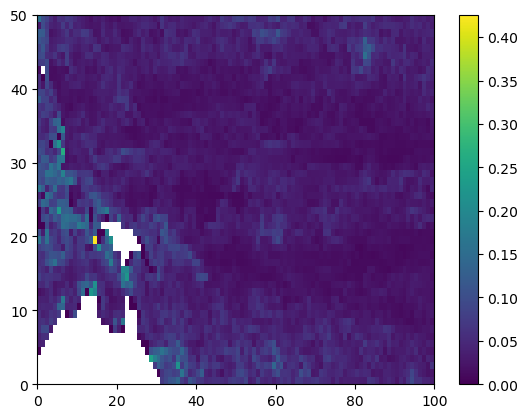

In [22]:
plt.figure()
plt.pcolormesh(fsle_std.isel(time=0).sel(lon_bin=slice(120,220), lat_bin=slice(-25,25)))
plt.colorbar()


In [5]:
%%time

DSphy = copernicusmarine.open_dataset(dataset_id="dataset-armor-3d-rep-monthly")
# Print memory usage in bytes (NumPy array)
print("Memory of each 4D dataarray (Gbytes):", DSphy.so.nbytes*1e-9)

DSphy_late = copernicusmarine.open_dataset(dataset_id="dataset-armor-3d-nrt-monthly")
print("Memory of each 4D dataarray (Gbytes):", DSphy_late.so.nbytes*1e-9)

DSphy_late



INFO - 2025-07-07T03:48:30Z - Selected dataset version: "202012"
INFO - 2025-07-07T03:48:30Z - Selected dataset part: "default"


Memory of each 4D dataarray (Gbytes): 71.43552000000001


INFO - 2025-07-07T03:48:45Z - Selected dataset version: "202012"
INFO - 2025-07-07T03:48:45Z - Selected dataset part: "default"


Memory of each 4D dataarray (Gbytes): 15.279264000000001
CPU times: user 2.79 s, sys: 1.15 s, total: 3.95 s
Wall time: 30.9 s


<xarray.Dataset>
Dimensions:    (depth: 50, latitude: 689, longitude: 1440, time: 77)
Coordinates:
  * depth      (depth) int16 0 5 10 15 20 25 ... 3000 3500 4000 4500 5000 5500
  * latitude   (latitude) float32 -82.12 -81.88 -81.62 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time       (time) datetime64[ns] 2019-01-01 2019-02-01 ... 2025-05-01
Data variables:
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(50, 689, 1440), meta=np.ndarray>
    so         (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 689, 1440), meta=np.ndarray>
    to         (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 689, 1440), meta=np.ndarray>
    ugo        (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 689, 1440), meta=np.ndarray>
    vgo        (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 689, 1440), meta=np.ndarray>
    zo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(50, 1, 689, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.0
    title:        ARMOR3D NRT - TSHUVMld Global Ocean Observation-based Produ...
    history:      2019-01-15 00:00:00 ARMOR3D NRT - TSHUV Global Ocean Observ...
    institution:  CLS

### save only the surface velocities

In [6]:
%%time

DSphy = DSphy.isel(depth=0)
DSphy_late = DSphy_late.isel(depth=0)

DSphy


CPU times: user 3.84 ms, sys: 2.1 ms, total: 5.94 ms
Wall time: 5.74 ms


<xarray.Dataset>
Dimensions:    (latitude: 689, longitude: 1440, time: 360)
Coordinates:
    depth      int16 0
  * latitude   (latitude) float32 -82.12 -81.88 -81.62 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2022-12-01
Data variables:
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(50, 689, 1440), meta=np.ndarray>
    so         (time, latitude, longitude) float32 dask.array<chunksize=(50, 689, 1440), meta=np.ndarray>
    to         (time, latitude, longitude) float32 dask.array<chunksize=(50, 689, 1440), meta=np.ndarray>
    ugo        (time, latitude, longitude) float32 dask.array<chunksize=(50, 689, 1440), meta=np.ndarray>
    vgo        (time, latitude, longitude) float32 dask.array<chunksize=(50, 689, 1440), meta=np.ndarray>
    zo         (time, latitude, longitude) float32 dask.array<chunksize=(50, 689, 1440), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.0
    title:        ARMOR3D REP - TSHUVMld Global Ocean Observation-based Produ...
    history:      1993-01-15 12:00:00 ARMOR3D REP - TSHUV Global Ocean Observ...
    institution:  CLS

In [14]:
%%time

ds1 = DSphy.compute()


[########################################] | 100% Completed | 30m 44s
CPU times: user 3min 18s, sys: 36 s, total: 3min 54s
Wall time: 30min 48s


In [13]:
%%time

ds2 = DSphy_late.compute()


[########################################] | 100% Completed | 327.88 s
CPU times: user 20.7 s, sys: 6.63 s, total: 27.4 s
Wall time: 5min 29s


In [15]:
%%time

ds = xr.concat([ds1, ds2], dim='time')
#del DSphy, DSphy_late, ds1, ds2
print("Memory of each 4D dataarray (Gbytes):", ds.ugo.nbytes*1e-9)
ds


Memory of each 4D dataarray (Gbytes): 2.03988096
CPU times: user 1.61 s, sys: 3.96 s, total: 5.57 s
Wall time: 5.57 s


<xarray.Dataset>
Dimensions:    (latitude: 689, longitude: 1440, time: 514)
Coordinates:
    depth      int16 0
  * latitude   (latitude) float32 -82.12 -81.88 -81.62 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * time       (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2025-05-01
Data variables:
    mlotst     (time, latitude, longitude) float32 nan nan nan ... 30.3 30.3
    so         (time, latitude, longitude) float32 nan nan nan ... 31.5 31.5
    to         (time, latitude, longitude) float32 nan nan nan ... -1.721 -1.721
    ugo        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    vgo        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
    zo         (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes:
    Conventions:  CF-1.0
    title:        ARMOR3D REP - TSHUVMld Global Ocean Observation-based Produ...
    history:      1993-01-15 12:00:00 ARMOR3D REP - TSHUV Global Ocean Observ...
    institution:  CLS

### take a look

CPU times: user 119 ms, sys: 13.3 ms, total: 132 ms
Wall time: 162 ms


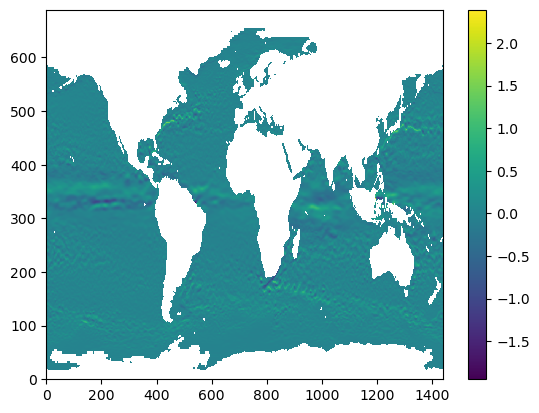

In [16]:
%%time

plt.figure()
plt.pcolormesh(ds.ugo.isel(time=0))
plt.colorbar()


### Calculate dx and dy

In [17]:
%%time

lat = ds.latitude.values  # shape (2041,)
lon = ds.longitude.values  # shape (4320,)

# Earth's radius in meters
R = 6371000  

# Convert degrees to radians
lat_rad = np.deg2rad(lat)
lon_rad = np.deg2rad(lon)

# Latitude spacing (dy): constant in degrees, but actual distance varies with latitude
dlat = np.gradient(lat_rad)  # shape (2041,)
dy = dlat * R  # meters between latitude lines

# Longitude spacing (dx): depends on latitude due to spherical convergence
dlon = np.gradient(lon_rad)  # shape (4320,)
dx = np.outer(np.cos(lat_rad), dlon) * R  # shape (2041, 4320)


CPU times: user 7.3 ms, sys: 0 ns, total: 7.3 ms
Wall time: 6.6 ms


### Calculate Okubo-Weiss

In [19]:
%%time

u_surf = ds.ugo
v_surf = ds.vgo

# Get gradients (2D)
du_dy = np.gradient(u_surf, axis=0) / dy[:, np.newaxis]
du_dx = np.gradient(u_surf, axis=1) / dx
dv_dy = np.gradient(v_surf, axis=0) / dy[:, np.newaxis]
dv_dx = np.gradient(v_surf, axis=1) / dx

strain = np.sqrt((du_dx - dv_dy)**2 + (dv_dx + du_dy)**2)
vorticity = dv_dx - du_dy
OW = strain**2 - vorticity**2


CPU times: user 24.1 s, sys: 20.4 s, total: 44.6 s
Wall time: 44.7 s


### take a look

In [21]:
np.shape(OW)

(514, 689, 1440)

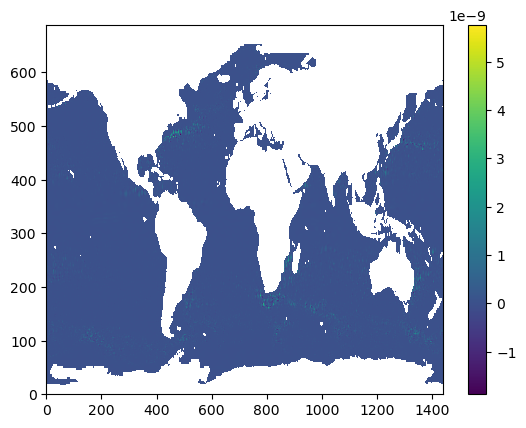

In [22]:
plt.figure()
plt.pcolormesh(OW[0,:,:])
plt.colorbar()

### regrid to coarse resolution

### saver to netcdf